In [188]:
import pandas as pd
import numpy as np
import os 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

In [189]:
sys.path.insert(1, os.path.join(sys.path[0], '../../../openAi/TS_analysis_TOPIC9/'))

In [190]:
from pyts_utils import descriptive_tools
from pyts_utils import proximity_tools
from cdlib import algorithms, ensemble,evaluation
from cdlib import viz
from sklearn.metrics import pairwise_distances

In [191]:
af_ex_pca = pd.read_csv('af_ex_pca.csv',index_col=0)

In [192]:
pivot_afex=af_ex_pca.pivot_table(values='af_ex_pca',columns='country',index='year')
pivot_afex=pivot_afex.drop(columns='Unspecified Area')

In [193]:
# pivot_afex=pivot_afex.where((~pd.notna(pivot_afex)) | (pivot_afex<1),1)
# pivot_afex=pivot_afex.where(~(pd.notna(pivot_afex)) | (pivot_afex>-1),-1)

### Euclidean distance as proximity measure in the network construction.

Clusters of antifragility time series (one series for each country from 1987 to 2017) were found considering euclidean distance as proximity measure (dissimilarity). An $\epsilon$-NN network was constructed setting $\epsilon = 2.8$ to connect pairs of nodes representing time series of antifragility with less than $\epsilon$ euclidean distance. I ignored the null values at the moment of computing the distances. This decision was made in order to allow countries with fewer datapoints, which usually are less developed, to be included in the analysis. Then I applied greedy_modularity and louvain community detection algorithms. 3 communities that minimize modularity were found by both algorithms. Averaging the antifragility time series of countries in each community, it can be seen that they represent antifragile, robust, and fragile groups of countries over time. I also calculated the adjusted rand index(ARI) and adjusted mutual information(AMI) to check the similarity between the communities found by each algorithm.

Below is a plot of the network, AMI and ARI estimations, and a general description of the groups found in terms of their antifragility values. Then, I show some plots that relate the groups of countries and other variables, specifically gdp, population, and sum of distances of exportations and importations.

In [197]:
# Distance_matrix = pd.DataFrame(pairwise_distances(pivot_afex.T,metric='nan_euclidean'),index=pivot_afex.columns,columns=pivot_afex.columns.copy())
Distance_matrix = 1-abs(pivot_afex.corr())

In [8]:
## ϵ-NN network construction
ϵ = 2.8

epsilon_NN = Distance_matrix[Distance_matrix < ϵ]
epsilon_NN = epsilon_NN.fillna(0)

In [9]:
G = nx.Graph()
for country1,series in epsilon_NN.iteritems():
    for country2,proximity in series.iteritems():
        if not np.equal(proximity,0):  
            G.add_edge(country1,country2)

In [10]:
#Greedy_modul
comm_greedy = algorithms.greedy_modularity(G)

# louvain
communities = algorithms.louvain(G)

ARI and AMI range from 0 to 1. Values close to 1 indicate that two different clustering results are similar in terms of objects belonging to the same groups in both cluster results.

In [11]:
print("ARI:",communities.adjusted_rand_index(comm_greedy).score)

ARI: 0.595007034863448


In [12]:
print('AMI:',communities.adjusted_mutual_information(comm_greedy).score)

AMI: 0.49398129475088864


In [13]:
print('Number of communities found by louvan and greedy modularity community detection algorithms:',len(communities.communities))

Number of communities found by louvan and greedy modularity community detection algorithms: 3


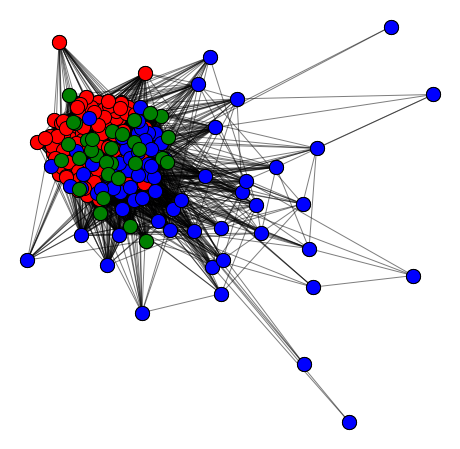

In [14]:
_=viz.plot_network_clusters(G,communities)

In [15]:
indices = [ index for index,group in enumerate(communities.communities) for count in group ]
countries = [c for g in communities.communities for c in g]

In [16]:
df_communities = pd.DataFrame(data=np.c_[countries,indices],columns=['country','labels'])

In [29]:
df_communities.to_excel('cluster.xlsx')

In [78]:
df_communities['country'].to_csv('community_countries.csv')

In [51]:
mergd_afex_communities = pivot_afex.T.merge(df_communities,on='country')

The following plot shows that considering medians (this is to have a more robust estimator of centrality so that patterns were not drastically affected by potential outliers), countries belonging to group 0 have positive antifragility values over time, group 1 is negative most of the time, particularly from 2006 to 2017, and group 3 is generally jumping around 0.

In [52]:
# fig,ax=plt.subplots(figsize=(20,8))
# for i,color in zip(df_communities['labels'].unique(),['blue','red','green']):
#     mergd_afex_communities[mergd_afex_communities['labels']==str(i)].T.drop(['country','labels']).plot(legend=False,c=color,alpha=0.3,ax=ax)
# mergd_afex_communities.groupby('labels').median().T.plot(figsize=(20,10),ax=ax,linewidth=3,color=['blue','red','green'])

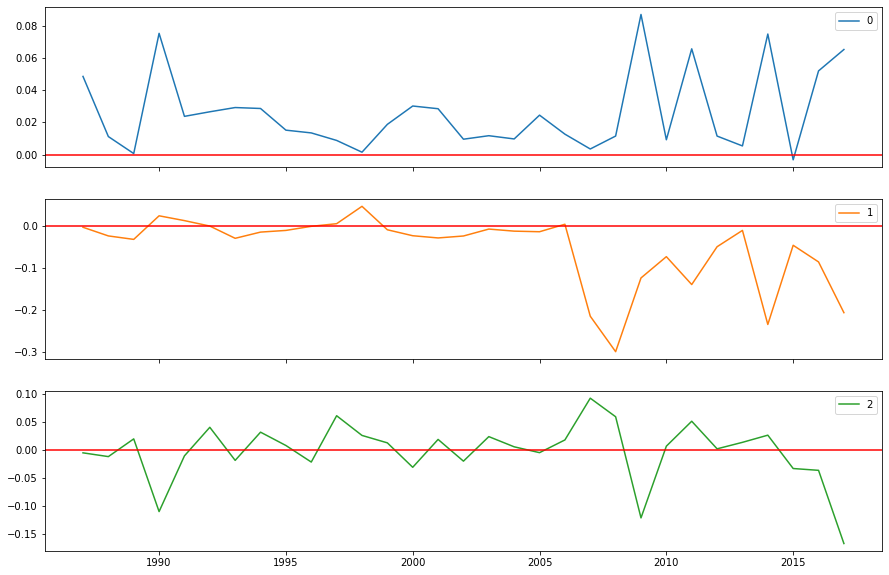

In [53]:
ax=mergd_afex_communities.groupby('labels').median().T.plot(subplots=True,figsize=(15,10))
for a in ax:
    a.axhline(0,c='red')

We can also see the behavior using a histogram and a box plot and draw some conclusions concerning the communities of countries found. Considering the box plot, approximately 90% of medians over time for group 1 are positive, around 85% of medians for group 2 are less negative, and more than 50% are positive (less than 40% negative) in the case of group 3.   

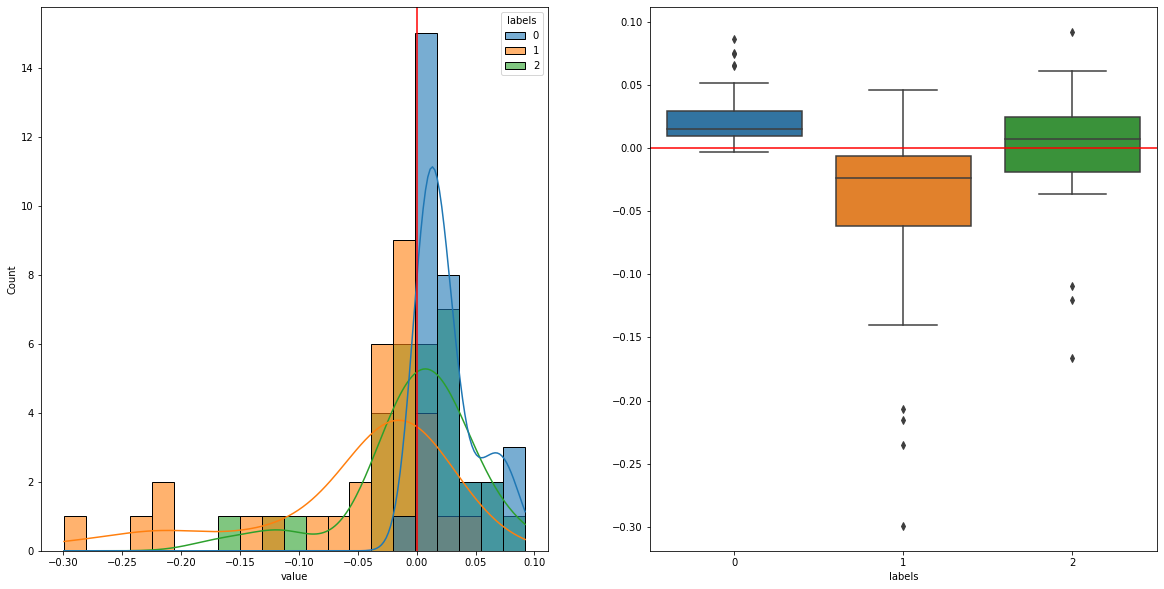

In [22]:
fig,axs=plt.subplots(1,2,figsize=(20,10))
sns.histplot(x='value',data=mergd_afex_communities.groupby('labels').median().T.melt(),hue='labels',kde=True,alpha=0.6,ax=axs[0])
axs[0].axvline(0,c='red')

sns.boxplot(data=mergd_afex_communities.groupby('labels').median().T,ax=axs[1])
_=axs[1].axhline(0,c='red')

Below is the number of countries per group

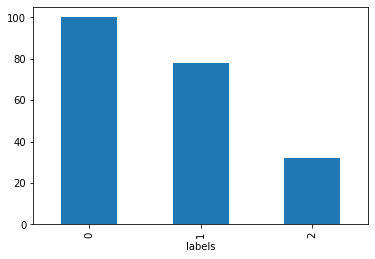

In [23]:
_=(mergd_afex_communities.groupby('labels').count()['country']).plot.bar() # Number of countries per community

In [69]:
pop=pd.read_csv('pairing_data/Population_clean.csv',index_col=0)
gdp = pd.read_csv('pairing_data/GDP_clean.csv',index_col=0)
distance = pd.read_csv('pairing_data/for_distance_pairing/distances_year_ex_im.csv',index_col=0) # distances in Km
trade_info = pd.read_csv('pairing_data/for_distance_pairing/trade_matrix_final.csv',index_col=0)


merged_pop_communities = pop.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_gdp_communities = gdp.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_pop_communities = merged_pop_communities[['date','value','country','labels']]
merged_gdp_communities = merged_gdp_communities[['date','value','country','labels']]


merged_distances_ex_communities = distance.groupby(['exporter','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns='exporter',axis=1)
merged_distances_in_communities = distance.groupby(['importer','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns='importer',axis=1)


trade_info_value = trade_info[trade_info['Unit'] == '1000 US$']
trade_info_quantity = trade_info[trade_info['Unit']=='tonnes']
merged_ex_food_value = trade_info_value.groupby(['exporter','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns='exporter',axis=1)
merged_ex_food_quantity = trade_info_quantity.groupby(['exporter','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns='exporter',axis=1)
merged_in_food_value = trade_info_value.groupby(['importer','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns='importer',axis=1)
merged_in_food_quantity = trade_info_quantity.groupby(['importer','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns='importer',axis=1)

Now, we plot group-averaged time series of GDP and pop, including confidence intervals for that estimate.

Text(0.5, 1.0, 'Population')

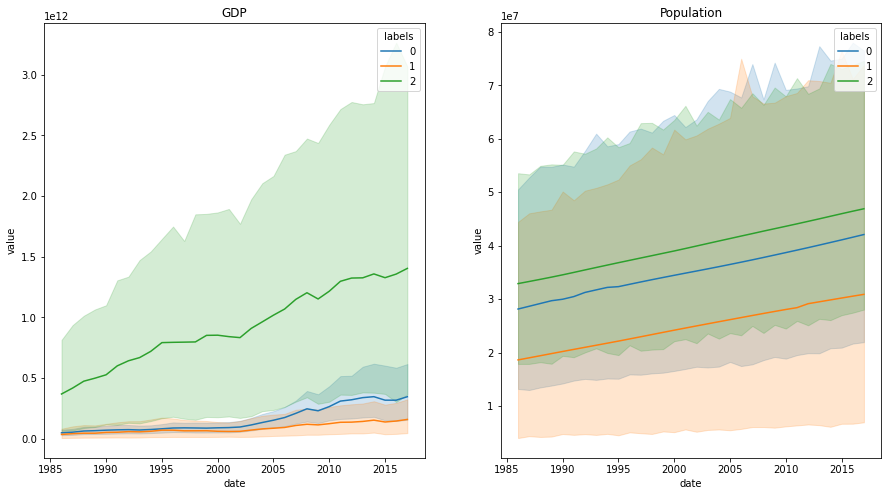

In [95]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
a=sns.lineplot(data=merged_gdp_communities,y='value',x='date',hue='labels',hue_order=['0','1','2'],ax=axs[0])
b=sns.lineplot(data=merged_pop_communities[['date','value','country','labels']],y='value',x='date',hue='labels',hue_order=['0','1','2'],ax=axs[1])
axs[0].set_title('GDP')
axs[1].set_title('Population')

The same type of time series as above are ploted below, but considering the sum of distances, which are computed between one country and each of the countries to/from which this country exported/imported food.

Text(0.5, 1.0, 'importation distances')

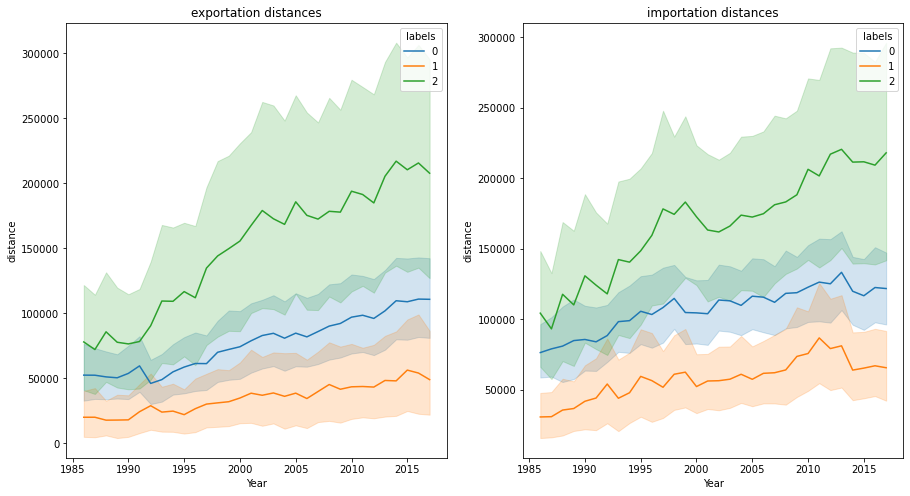

In [26]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
sns.lineplot(data=merged_distances_ex_communities,y='distance',x='Year',hue='labels',hue_order=['0','1','2'],ax=axs[0])
sns.lineplot(data=merged_distances_in_communities,y='distance',x='Year',hue='labels',hue_order=['0','1','2'],ax=axs[1])
axs[0].set_title('exportation distances')
axs[1].set_title('importation distances')

From the previous time series plots, we can say that the group averaged sum of exportation/importation distances time series are statistically different from each other based on the confidence intervals over time. Therefore, considering countries belonging to group 1, which we could say are fragile over time, their time series of average sum of distances of exportations and importations are consistently lower over time, compared to group 0, which are antifragile, and this group, in turn, is consistently lower over time than group 2 of robust countries. The next part shows the same type of group averages time series but considering the sum of value (per 1000 US$) or sum of quantity (in tonnes) computed between one country and each of the countries to/from which this country exported/imported food.

Text(0.5, 1.0, 'importation quantity sum')

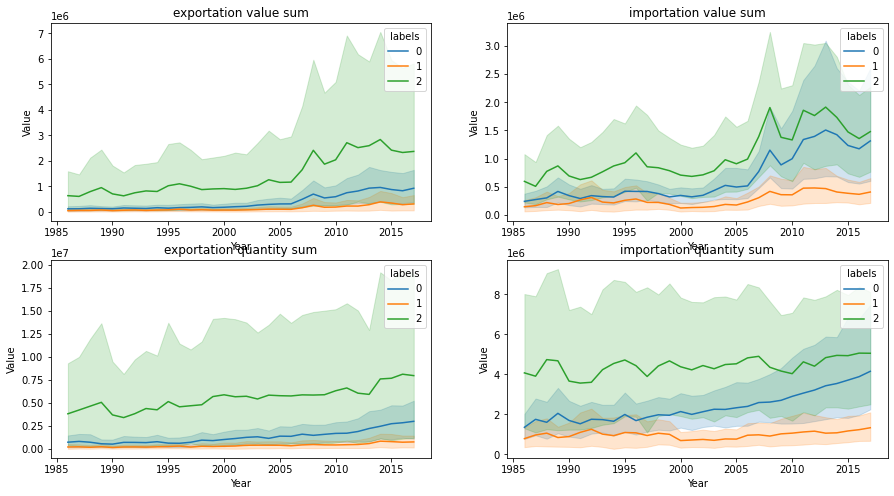

In [97]:
fig,axs=plt.subplots(2,2,figsize=(15,8))
sns.lineplot(data=merged_ex_food_value,y='Value',x='Year',hue='labels',hue_order=['0','1','2'],ax=axs[0,0])
sns.lineplot(data=merged_in_food_value,y='Value',x='Year',hue='labels',hue_order=['0','1','2'],ax=axs[0,1])
axs[0,0].set_title('exportation value sum')
axs[0,1].set_title('importation value sum')

sns.lineplot(data=merged_ex_food_quantity,y='Value',x='Year',hue='labels',hue_order=['0','1','2'],ax=axs[1,0])
sns.lineplot(data=merged_in_food_quantity,y='Value',x='Year',hue='labels',hue_order=['0','1','2'],ax=axs[1,1])
axs[1,0].set_title('exportation quantity sum')
axs[1,1].set_title('importation quantity sum')

The rest of time series don't exhibit clear statistical supported differences. Nevertheless, one aspect that should be considered is that due to the different group sizes and unequal variances per year, the power of the test that the group averages are different is lower. Therefore, given that the averages are different is true, the probability to reject the null, i.e., that the averages are equal, is lower. Thus, testing the group differenece of averages using, for example, one-way ANOVA, would have lower statistical sensitivity.

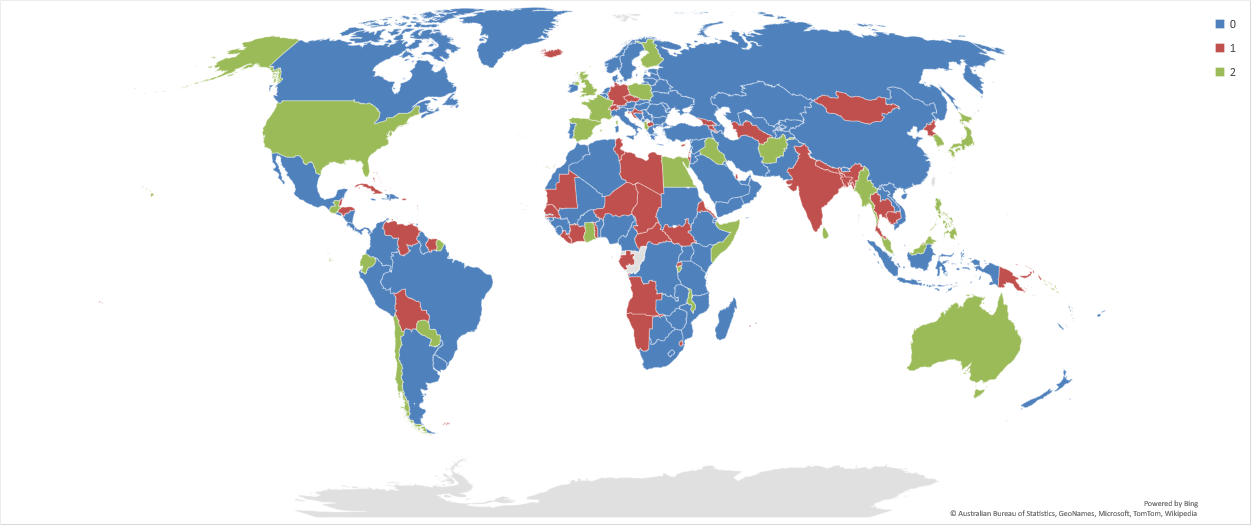

Finally, using the same methodology of network construction and community discovery algorithms, I also constructed networks using correlation as proximity measure. At first, I used a time-lag variation of correlation (cross-correlation), nonetheless, the time-frequency of this data is yearly, hence, I considered that any possible lagged effects of one country over another could not be carried for more than 1 year. Furthermore, using simple correlation allowed the use of NaN-friendly methods such that all the countries were included. I decided not to apply it due to the small number of observations we have in our dataset (exactly 31) and the added complication of correcting for small sample sizes in the mutual information estimation.

In the correlation case, the number of communities found by louvain were 6. The interpretation of groups in this case is that countries belonging to the same group have similar geometric profiles (shapes) of antifragility time series over time. Therefore, we could think about them as behaving somewhat coordinated throughout the years in terms of their antifragility dynamics.

### Correlation as proximity measure in the network construction

In [211]:
## ϵ-NN network construction
ϵ = 0.45

epsilon_NN = Distance_matrix[Distance_matrix < ϵ]
epsilon_NN = epsilon_NN.fillna(0)

G = nx.Graph()
for country1,series in epsilon_NN.iteritems():
    for country2,proximity in series.iteritems():
        if not np.equal(proximity,0):  
            G.add_edge(country1,country2)

In [212]:
#Greedy_modul
comm_greedy = algorithms.greedy_modularity(G)

# louvain
communities = algorithms.louvain(G)

In [213]:
indices = [ index for index,group in enumerate(communities.communities) for count in group ]
countries = [c for g in communities.communities for c in g]

In [214]:
df_communities = pd.DataFrame(data=np.c_[countries,indices],columns=['country','labels'])

In [215]:
df_communities.to_excel('cluster_correlation.xlsx')

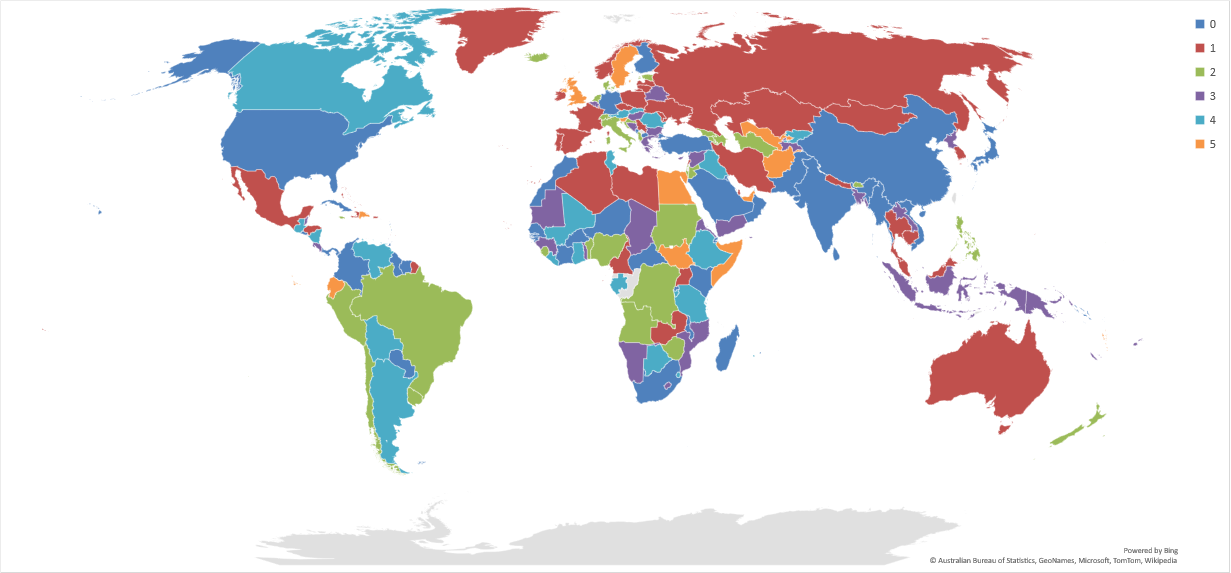

In [96]:
# fig,axs=plt.subplots(2,2,figsize=(15,8))
# sns.boxplot(data=merged_gdp_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,0])
# sns.boxplot(data=merged_pop_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,1])
# sns.boxplot(data=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,0])
# sns.boxplot(data=merged_distances_in_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,1])